# Non-Iterative Subgraph Screening

In [1]:
import numpy as np
import random

np.random.seed(10)

import graspy
from graspy.simulations import sbm
from graspy.plot import heatmap
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/numba-0.46.0-py3.6-linux-x86_64.egg/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Subgraph Screening uses rows of adjacency matrices as feature vectors for each node, and finds the correlation of those feature vectors with a covariate of interest. Mathematically speaking, for m graphs, there are m covariates. The correlation values found from screening are 

\begin{align*}
c_{u} = MGC\left(\left\{(\hat{X_{i}}[u,\cdot], Y_{i})\right\}^{m}_{i = 1}\right)
\end{align*}

for covariates of interest $\left\{ Y_{i} \in \mathbb{R}, i = 1, ..., m\right\}$ and feature vectors $\hat{X_{i}}[u,.] = A_{i}[u,\cdot]$, where $A_{i}[u,\cdot]$ is the corresponding row in the adjacency matrix. 

For non-iterative screening, all of these correlation values for each node are returned as a list. Also, the indices of every node with correlation value higher than a set threshold value $c$ are returned. This estimated signal subgraph is $\hat{S} = \left\{u \in V|c_{u} > c\right\}$, where $V = [n]$ for adjacency matrices in $\mathbb{R}^{n \ \times \ n}$.

## Generate Mock Data

In [2]:
# Create function to generate mock data

def data_generator(num_graphs, N, n, prob_tensor, percent_vec):

    # Getting the number of classes
    num_types = len(percent_vec)

    # Getting vector with the number of graphs in each class
    num = [int(num_graphs * a) for a in percent_vec]

    # Creating blank arrays for all of the returns
    data = np.zeros((num_graphs, N, N))
    y_label = np.zeros((num_graphs, 1))

    # Creates vector of random indices to randomly distribute graphs in tensor
    L_ind = random.sample(range(0, num_graphs), num_graphs)

    # Loop for creating the returns
    for i in range(num_types):

        # Create tensor that will contain all of the graphs of one type
        types = np.zeros((num[i], N, N))

        # Put all the graphs of one type into types
        for j in range(len(types)):
            types[j] = sbm(n=n, p=prob_tensor[i])

        # Assigns all of the graphs in types to random indices in data
        data[L_ind[: num[i]]] = types

        # Creates corresponding labels
        y_label[L_ind[: num[i]]] = int(i)

        # Gets rid of used indices
        L_ind = L_ind[num[i] :]

    return data, y_label

In [3]:
prob_tensor = np.zeros((2, 2, 2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])
data_samp, y_label_samp = data_generator(100, 200, n, prob_tensor, percent_vec)

#Create signal subgraph label vector, 
#indicating which nodes are in the signal subgraph.

ss_label = np.zeros(200)
ss_label[:20] = 1

## Usage

In [4]:
from graspy.subgraph import NonItScreen

# Screening with Multiscale Graph Correlation (MGC)
screen = NonItScreen("mgc", 0.001)

#Correlations
screen.fit(data_samp, y_label_samp)

#Estimated Signal Subgraph
S_hat = screen.fit_transform(data_samp, y_label_samp)

In [5]:
# Print Correlation Values and Estimated Signal Subgraph
print(screen.corrs)

print(S_hat)

[[ 1.59255316e-02]
 [ 2.42905074e-02]
 [ 3.08683820e-02]
 [ 1.87235722e-02]
 [ 9.41052571e-03]
 [ 5.78032579e-02]
 [ 1.23678510e-02]
 [ 2.16941550e-02]
 [ 6.47256218e-04]
 [ 2.68525196e-02]
 [ 1.59582956e-02]
 [-2.39533037e-03]
 [ 8.04040018e-02]
 [ 1.89949569e-02]
 [ 2.73119212e-02]
 [ 1.87071193e-03]
 [ 1.03226242e-02]
 [ 8.42161469e-02]
 [ 2.16064972e-02]
 [ 3.95805228e-03]
 [ 1.11157337e-02]
 [-1.54947240e-02]
 [ 1.00064066e-02]
 [-7.13744932e-03]
 [ 3.56786033e-03]
 [-1.86177524e-02]
 [-5.33762541e-03]
 [-2.32233776e-03]
 [-6.97225129e-04]
 [ 1.61806091e-02]
 [ 8.36742486e-04]
 [ 9.60026325e-03]
 [-1.09641614e-02]
 [ 1.54367766e-02]
 [ 1.00597168e-02]
 [-7.86416950e-04]
 [ 2.16825628e-03]
 [ 1.42132763e-02]
 [ 1.65536526e-02]
 [ 1.52827011e-03]
 [-1.53568907e-02]
 [ 6.06485571e-02]
 [ 1.75085573e-03]
 [ 2.09953236e-02]
 [ 2.85282625e-03]
 [ 5.53594138e-02]
 [-2.81378350e-03]
 [-1.23487600e-02]
 [ 6.73496439e-03]
 [-1.17496991e-02]
 [-1.33347676e-02]
 [ 4.15896387e-03]
 [-3.0213545

Estimation for the Signal Subgraph Nodes:
[  0   1   2   3   4   5   6   7   9  10  12  13  14  15  16  17  18  19
  20  22  24  29  31  33  34  36  37  38  39  41  42  43  44  45  48  51
  57  60  62  63  64  66  68  69  71  73  74  76  77  79  80  83  86  90
  93  95  96  97  98  99 100 101 103 104 107 108 110 113 114 115 118 119
 121 122 123 125 127 128 131 132 133 134 135 137 138 146 147 148 150 152
 157 158 160 161 163 164 171 172 173 176 179 182 183 188 189 190 191 192
 193 194 196 197 199]


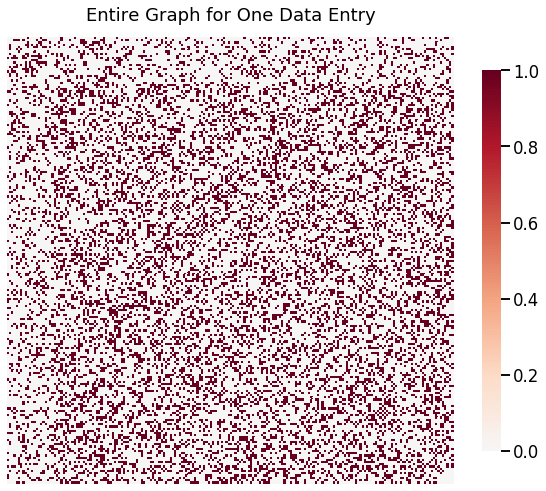

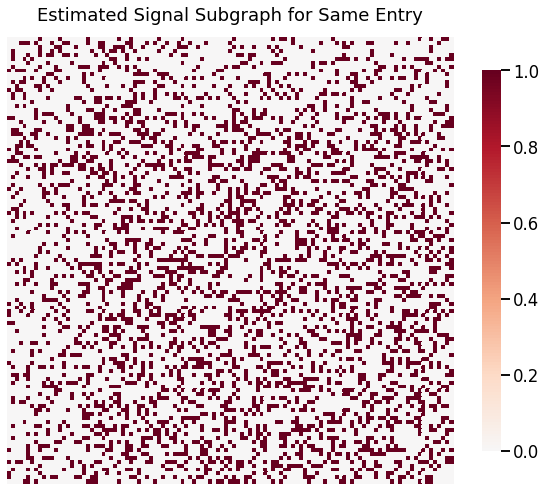

In [7]:
# Visualizing the Data

heatmap(data_samp[0], title='Entire Graph for One Data Entry')

heatmap(S_hat[0], title='Estimated Signal Subgraph for Same Entry')

print("Estimation for the Signal Subgraph Nodes:")
print(screen.subgraph_verts)

## Accuracy

The AUC value is the area under the ROC curve.
This is a measurement of the accuracy of the estimation.
The closer to 1, the better.
AUC Value: 0.7986111111111112


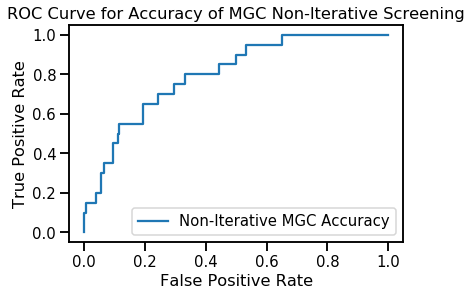

In [8]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(ss_label, screen.corrs)

sns.set_context("talk", font_scale=0.90)
plt.title("ROC Curve for Accuracy of MGC Non-Iterative Screening")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.step(fpr, tpr, label="Non-Iterative MGC Accuracy")
plt.legend()

auc_val = metrics.auc(fpr, tpr)
print("The AUC value is the area under the ROC curve.")
print("This is a measurement of the accuracy of the estimation.")
print("The closer to 1, the better.")
print("AUC Value:", auc_val)

## Generate Mock Data

In [9]:
# 3 Types
prob_tensor = np.zeros((3, 2, 2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
prob_tensor[2] = [[0.5, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.30, 0.30, 0.40])
data_samp, y_label_samp = data_generator(100, 200, n, prob_tensor, percent_vec)

#Create signal subgraph label vector, 
#indicating which nodes are in the signal subgraph.

ss_label = np.zeros(200)
ss_label[:20] = 1

In [10]:
# Now with Distance Correlation (DCORR)
screen = NonItScreen("dcorr", 0.12)

#Correlations
screen.fit(data_samp, y_label_samp)

#Estimated Signal Subgraph
S_hat = screen.fit_transform(data_samp, y_label_samp)

Estimation for the Signal Subgraph Nodes:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  19  22  23  24  25  31  32  37  45  46  47  48  49  51  59  61  63  65
  67  71  75  79  80  82  85  88  89  92  95  98 102 106 109 111 116 117
 121 123 124 128 129 130 131 133 137 143 144 146 150 152 154 160 163 165
 166 167 168 175 176 177 181 184 189 192 193 195 198]


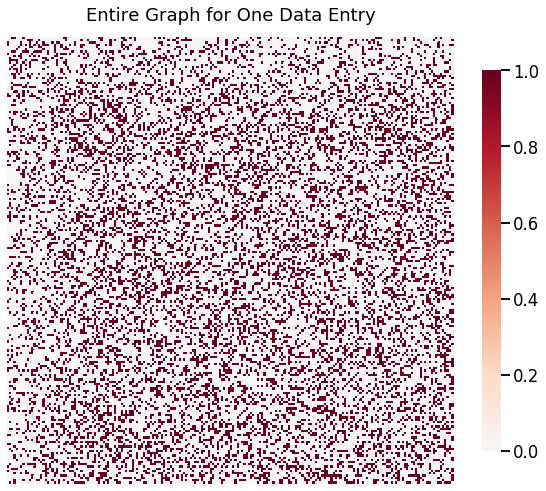

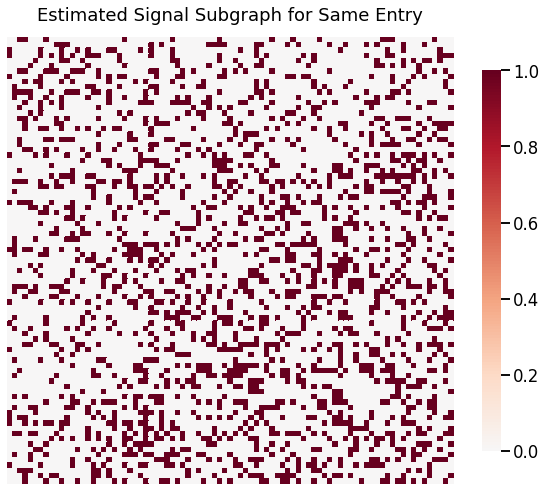

In [12]:
# Visualizing the Data

heatmap(data_samp[0], title='Entire Graph for One Data Entry')

heatmap(S_hat[0], title='Estimated Signal Subgraph for Same Entry')

print("Estimation for the Signal Subgraph Nodes:")
print(screen.subgraph_verts)

## Accuracy

AUC Value: 0.9358333333333333


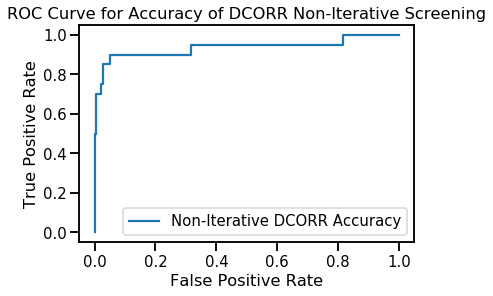

In [13]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(ss_label, screen.corrs)

sns.set_context("talk", font_scale=0.90)
plt.title("ROC Curve for Accuracy of DCORR Non-Iterative Screening")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.step(fpr, tpr, label="Non-Iterative DCORR Accuracy")
plt.legend()

auc_val = metrics.auc(fpr, tpr)
print("AUC Value:", auc_val)